In [1]:
# DataSource- https://www.nseindia.com/market-data/live-equity-market
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import os
import tensorflow as tf
from google.colab import files, drive
import io
import seaborn as sns
import h5py

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


1

In [ ]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:


# df = pd.read_csv('gdrive/My Drive/Colab Notebooks/MidcapSmall400-01-Sep-2020.csv')
df = pd.read_csv('gdrive/My Drive/Colab Notebooks/Nifty50data.csv')

df.head()

,Date,Open,High,Low,Close,Shares Traded,Turnover (Rs. Cr)
0,26-Aug-2019,11000.30,11070.30,10756.55,11057.85,684141923,22375.99
1,27-Aug-2019,11106.55,11141.75,11049.50,11105.35,685551267,27413.16
2,28-Aug-2019,11101.30,11129.65,10987.65,11046.10,549954696,16739.43
3,29-Aug-2019,10996.05,11021.10,10922.40,10948.30,649876160,20127.77
4,30-Aug-2019,10987.80,11042.60,10874.80,11023.25,628154431,21057.31


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401 entries, 0 to 400
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   SYMBOL 
                    401 non-null    object 
 1   OPEN 
                      401 non-null    float64
 2   HIGH 
                      401 non-null    float64
 3   LOW 
                       401 non-null    float64
 4   PREV. CLOSE 
               401 non-null    float64
 5   LTP 
                       401 non-null    float64
 6   CHNG 
                      401 non-null    object 
 7   %CHNG 
                     401 non-null    object 
 8   VOLUME 
(shares)            401 non-null    int64  
 9   VALUE                       401 non-null    float64
 10  52W H 
                     401 non-null    float64
 11  52W L 
                     401 non-null    float64
 12  365 D % CHNG 
 30-Aug-2019  401 non-null    object 
 13  30 D % CHNG 
 31-Jul-2020   401 non

In [ ]:
# preprocessing data
df= df['Open'].values
df= df.reshape(-1,1)
print(df.shape)
df[:7]

(247, 1)


array([[11000.3 ],
       [11106.55],
       [11101.3 ],
       [10996.05],
       [10987.8 ],
       [10960.95],
       [10790.4 ]])

In [ ]:
train_data= np.array(df[:int(df.shape[0]*0.8)])
test_data= np.array(df[int(df.shape[0]*0.8)-50:])
print(train_data.shape)
print(test_data.shape)

(197, 1)
(100, 1)


In [ ]:
scaler= MinMaxScaler(feature_range=(0,1))
train_data= scaler.fit_transform(train_data)
train_data[:7]

array([[0.69540077],
       [0.71802954],
       [0.71691141],
       [0.69449562],
       [0.69273856],
       [0.68702014],
       [0.65069697]])

In [ ]:
test_data= scaler.transform(test_data) #why we not used fit transform because we should not harm the scalar= MinMaxScaler(feature_range=(0,1))
                                    # because the test data is the data which model never seen before. 
test_data[:7]

array([[0.13860522],
       [0.16914607],
       [0.18080654],
       [0.1323437 ],
       [0.15145836],
       [0.2031265 ],
       [0.26364382]])

In [ ]:
def create_my_dataset(df):
    x=[]
    y=[]
    for i in range(50,df.shape[0]):
        x.append(df[i-50:i,0])
        y.append(df[i,0])
    x = np.array(x)
    y = np.array(y)
    
    return x,y

In [ ]:
x_train, y_train = create_my_dataset(train_data)
x_train[:1]

array([[0.69540077, 0.71802954, 0.71691141, 0.69449562, 0.69273856,
        0.68702014, 0.65069697, 0.66572247, 0.67058899, 0.68185545,
        0.70140671, 0.70775342, 0.69252558, 0.69424005, 0.69535817,
        0.66824624, 0.66236809, 0.64141118, 0.81091931, 0.82114219,
        0.81563675, 0.79540396, 0.81382645, 0.79994037, 0.80510505,
        0.76396861, 0.77806766, 0.7371229 , 0.72791166, 0.75507683,
        0.75022096, 0.76687574, 0.77218951, 0.79436038, 0.7946479 ,
        0.81892724, 0.83529449, 0.82231357, 0.83625289, 0.83295175,
        0.83638067, 0.8324832 , 0.88358695, 0.88498195, 0.88416199,
        0.8931709 , 0.90290394, 0.88946511, 0.91280735, 0.90557679]])

In [ ]:
x_test, y_test = create_my_dataset(test_data)
x_test[:2]

array([[0.13860522, 0.16914607, 0.18080654, 0.1323437 , 0.15145836,
        0.2031265 , 0.26364382, 0.29152246, 0.31121216, 0.23770326,
        0.33827084, 0.35248704, 0.27299349, 0.27508066, 0.31886867,
        0.30429041, 0.32469358, 0.35240184, 0.35640581, 0.42986146,
        0.38300659, 0.36083572, 0.31768665, 0.31923073, 0.34966509,
        0.34353137, 0.30534465, 0.39380451, 0.3149499 , 0.30823048,
        0.30309775, 0.26122653, 0.24577508, 0.28630454, 0.28384465,
        0.29062796, 0.28689022, 0.34710937, 0.35930229, 0.42418563,
        0.45698404, 0.50542558, 0.49391419, 0.50233742, 0.55195033,
        0.52094093, 0.49782231, 0.50240131, 0.38544517, 0.46518364],
       [0.16914607, 0.18080654, 0.1323437 , 0.15145836, 0.2031265 ,
        0.26364382, 0.29152246, 0.31121216, 0.23770326, 0.33827084,
        0.35248704, 0.27299349, 0.27508066, 0.31886867, 0.30429041,
        0.32469358, 0.35240184, 0.35640581, 0.42986146, 0.38300659,
        0.36083572, 0.31768665, 0.31923073, 0.3

In [ ]:
# reshaping the data for our LSTM model

x_train= np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test= np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(x_test.shape)
print(x_train.shape) 
# in ('train data', 'test data' ,'feature vector' ) the results 50 is the input to model and 1 is the feature that is 'open' column

(50, 50, 1)
(147, 50, 1)


In [ ]:
# tf.logging.set_verbosity(tf.logging.ERROR)
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50, 96)            37632     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 96)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50, 96)            74112     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50, 96)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 96)                74112     
_________________________________________________________________
dropout_5 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [ ]:
model.compile(loss='mean_squared_error', optimizer ='adam')

In [ ]:
if(not os.path.exists(r'gdrive/My Drive/Colab Notebooks/stock_predictionNifty50.h5')):
    model.fit(x_train, y_train, epochs=50, batch_size=32)
    model.save(r'gdrive/My Drive/Colab Notebooks/stock_predictionNifty50.h5')
    # h5py.h5f.create(')
    # model.save(r'/home/sagar/Downloads/StockMarketFilePath/stock_prediction.h5')

Epoch 1/50
5/5 [==============================] - 0s 91ms/step - loss: 0.1936
Epoch 2/50
5/5 [==============================] - 0s 94ms/step - loss: 0.1042
Epoch 3/50
5/5 [==============================] - 0s 86ms/step - loss: 0.0521
Epoch 4/50
5/5 [==============================] - 0s 91ms/step - loss: 0.0356
Epoch 5/50
5/5 [==============================] - 0s 85ms/step - loss: 0.0262
Epoch 6/50
5/5 [==============================] - 0s 90ms/step - loss: 0.0246
Epoch 7/50
5/5 [==============================] - 0s 91ms/step - loss: 0.0179
Epoch 8/50
5/5 [==============================] - 0s 87ms/step - loss: 0.0143
Epoch 9/50
5/5 [==============================] - 0s 89ms/step - loss: 0.0144
Epoch 10/50
5/5 [==============================] - 0s 86ms/step - loss: 0.0141
Epoch 11/50
5/5 [==============================] - 0s 88ms/step - loss: 0.0121
Epoch 12/50
5/5 [==============================] - 0s 94ms/step - loss: 0.0136
Epoch 13/50
5/5 [==============================] - 0s 89ms/st

In [ ]:
model = load_model(r'gdrive/My Drive/Colab Notebooks/stock_predictionNifty50.h5')

range(197, 247)


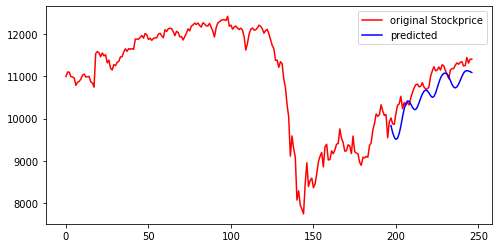

In [ ]:
#visualizing our predictions
%matplotlib inline
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

fig, ax = plt.subplots(figsize=(8,4))
plt.plot(df, color='red', label='original Stockprice')
ax.plot(range(len(y_train)+50, len(y_train)+50+len(predictions)),predictions,color='blue', label='predicted')
plt.legend()
print(range(len(y_train)+50, len(y_train)+50+len(predictions)))

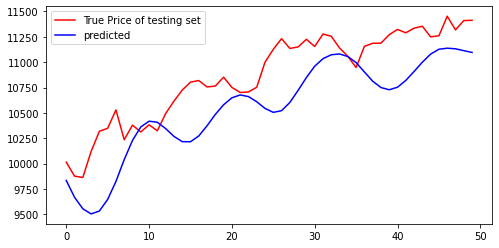

In [ ]:
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1,1))

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(y_test_scaled, color='red', label = 'True Price of testing set')
plt.plot(predictions, color = 'blue', label='predicted')
plt.legend()